In [41]:
import os
import warnings
import numpy as np
import pandas as pd
from copy import deepcopy
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import layers, regularizers
from keras.layers import Dense, Dropout, Flatten
# from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_auc_score

In [2]:
def checkLatestVersion():
    if(os.path.exists("./dly532.csv")):
        os.remove("./dly532.csv")
        print("Deleted previous CSV file.")
        print("Downloading latest CSV file.")
        os.system("wget https://cli.fusio.net/cli/climate_data/webdata/dly532.csv")
        print("Downloaded dataset.")
    else:
        print("Downloading dataset.")
        os.system("wget https://cli.fusio.net/cli/climate_data/webdata/dly532.csv")
        print("Downloaded dataset.")
    return None

In [3]:
checkLatestVersion()

Deleted previous CSV file.
Downloaded dataset.


In [4]:
with open("dly532.csv", "r") as reading:
    data = reading.read().splitlines(True)
reading.close()
os.remove("./dly532.csv")
with open("dly532.csv", "w") as writing:
    writing.writelines(data[26:])
writing.close()

# Reading the raw dataset

In [5]:
names = ["DATE", "INDICATOR0","MAX_AIR_TEMP",
           "INDICATOR1","MIN_AIR_TEMP","I_GRASS_MIN_TEMP",
           "GRASS_MIN_TEMP","INDICATOR2","RAIN_MM",
           "MEAN_CBL_PRESSURE","MEAN_WINDSPEED_KNOT","INDICATOR3",
           "HIGHEST_10MIN_WINDSPEED","INDICATOR4","WIND_DIR_DEGREE",
           "INDICATOR5","HIGHEST_GUST","SUN_DURATION","DOS",
           "GLOBAL_RADIATION","SOIL_TEMP","POTENTIAL_EVAPOTRANSPIRATION",
           "EVAPORATION","SMD_WELL_DRAINED","SMD_MODERATELY_DRAINED","SMD_POORLY_DRAINED"]
read_data = pd.read_csv("dly532.csv", names = names)
read_data

,DATE,INDICATOR0,MAX_AIR_TEMP,INDICATOR1,MIN_AIR_TEMP,I_GRASS_MIN_TEMP,GRASS_MIN_TEMP,INDICATOR2,RAIN_MM,MEAN_CBL_PRESSURE,...,HIGHEST_GUST,SUN_DURATION,DOS,GLOBAL_RADIATION,SOIL_TEMP,POTENTIAL_EVAPOTRANSPIRATION,EVAPORATION,SMD_WELL_DRAINED,SMD_MODERATELY_DRAINED,SMD_POORLY_DRAINED
0,01-jan-1942,0,9.7,0,6.8,0,4.7,2,0.0,1020.3,...,,0.0,0,,,1.1,1.4,,,
1,02-jan-1942,0,9.9,0,7.9,0,6.7,0,0.1,1016.2,...,,0.0,0,,,0.7,0.9,,,
2,03-jan-1942,0,11.2,0,8.9,0,7.2,0,1.5,1006.8,...,,0.1,0,,,0.5,0.6,,,
3,04-jan-1942,0,9.2,0,2.7,0,3.4,0,3.5,1001.5,...,,0.6,0,,,0.6,0.7,,,
4,05-jan-1942,0,3.5,1,-0.8,0,0.0,0,0.6,1013.4,...,,3.4,0,,,0.6,0.7,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28819,26-nov-2020,0,7.5,0,1.3,0,1.1,3,0.0,1011.1,...,14,0.0,0,203,5.375,0.2,0.3,0.4,0.4,-8.6
28820,27-nov-2020,0,7.9,1,-1.2,1,-5.5,0,0.2,1008.2,...,12,4.7,0,345,4.975,0.1,0.2,0.3,0.3,-8.3
28821,28-nov-2020,0,10.2,0,0.6,1,-3.7,3,0.0,1008.3,...,15,0.6,0,222,4.800,0.3,0.4,0.6,0.6,-7.6
28822,29-nov-2020,0,10.8,0,1.9,1,-0.8,3,0.0,1015.1,...,14,1.9,0,198,6.650,0.2,0.3,0.8,0.8,-7.0


# Pre-processing the data.

Removing empty values and the old rows with irrelevant data (till 28-oct-1979).

In [6]:
read_data = pd.read_csv("dly532.csv", names = names)
read_data = read_data.replace(r'^\s*$', np.nan, regex=True)
read_data = read_data[read_data["SMD_POORLY_DRAINED"].notna()]
read_data

,DATE,INDICATOR0,MAX_AIR_TEMP,INDICATOR1,MIN_AIR_TEMP,I_GRASS_MIN_TEMP,GRASS_MIN_TEMP,INDICATOR2,RAIN_MM,MEAN_CBL_PRESSURE,...,HIGHEST_GUST,SUN_DURATION,DOS,GLOBAL_RADIATION,SOIL_TEMP,POTENTIAL_EVAPOTRANSPIRATION,EVAPORATION,SMD_WELL_DRAINED,SMD_MODERATELY_DRAINED,SMD_POORLY_DRAINED
13814,28-oct-1979,0,12.0,0,4.5,1,-1.9,0,0.9,997.9,...,22,4.2,0,573,9.350,0.7,0.9,0.0,-0.2,-0.2
13815,29-oct-1979,0,11.0,0,4.0,0,2.7,0,0.7,998.8,...,17,0.4,0,417,8.625,0.6,0.8,0.0,-0.1,-0.3
13816,30-oct-1979,0,15.7,0,8.8,0,7.4,0,4.8,990.8,...,36,0.6,0,247,10.550,0.8,1.0,0.0,-4.0,-4.4
13817,31-oct-1979,0,12.6,0,7.1,0,5.3,0,0.5,990.0,...,37,6.7,0,577,9.875,1.0,1.2,0.5,0.5,-3.7
13818,01-nov-1979,0,11.4,0,5.5,0,4.0,2,0.0,1001.6,...,27,7.0,0,585,8.175,1.2,1.5,1.6,1.6,-2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28819,26-nov-2020,0,7.5,0,1.3,0,1.1,3,0.0,1011.1,...,14,0.0,0,203,5.375,0.2,0.3,0.4,0.4,-8.6
28820,27-nov-2020,0,7.9,1,-1.2,1,-5.5,0,0.2,1008.2,...,12,4.7,0,345,4.975,0.1,0.2,0.3,0.3,-8.3
28821,28-nov-2020,0,10.2,0,0.6,1,-3.7,3,0.0,1008.3,...,15,0.6,0,222,4.800,0.3,0.4,0.6,0.6,-7.6
28822,29-nov-2020,0,10.8,0,1.9,1,-0.8,3,0.0,1015.1,...,14,1.9,0,198,6.650,0.2,0.3,0.8,0.8,-7.0


Checking the data types of each column.

In [7]:
read_data.dtypes

DATE                             object
INDICATOR0                        int64
MAX_AIR_TEMP                    float64
INDICATOR1                        int64
MIN_AIR_TEMP                    float64
I_GRASS_MIN_TEMP                  int64
GRASS_MIN_TEMP                   object
INDICATOR2                        int64
RAIN_MM                         float64
MEAN_CBL_PRESSURE               float64
MEAN_WINDSPEED_KNOT             float64
INDICATOR3                        int64
HIGHEST_10MIN_WINDSPEED          object
INDICATOR4                        int64
WIND_DIR_DEGREE                  object
INDICATOR5                        int64
HIGHEST_GUST                     object
SUN_DURATION                    float64
DOS                              object
GLOBAL_RADIATION                 object
SOIL_TEMP                        object
POTENTIAL_EVAPOTRANSPIRATION    float64
EVAPORATION                      object
SMD_WELL_DRAINED                 object
SMD_MODERATELY_DRAINED           object


Building the target values.

In [8]:
read_data.loc[read_data["RAIN_MM"] == 0, "RAIN_BOOLEAN"] = 0
read_data.loc[read_data["RAIN_MM"] > 0, "RAIN_BOOLEAN"] =  1

Removing columns not related to the problem statement.

In [9]:
# # Extracting Year , Month and Day from Column Date

# read_data['YEAR'] = read_data['DATE'].dt.year
# read_data['MONTH'] = read_data['DATE'].dt.month
# read_data['DAY'] = read_data['DATE'].dt.day

In [10]:
target_Arr = np.array([int(i) for i in read_data["RAIN_BOOLEAN"]])
print(target_Arr)
print(len(target_Arr))
count = 0
for i in target_Arr:
    if i == 0:
        count+=1
print("0 : ",count)
print("1 : ",len(target_Arr)-count)
# print(read_data.dtypes)

[1 1 1 ... 0 0 1]
15010
0 :  6114
1 :  8896


### Converting object to float data types

In [11]:
read_data['HIGHEST_10MIN_WINDSPEED'] = read_data['HIGHEST_10MIN_WINDSPEED'].astype(float)
read_data['WIND_DIR_DEGREE'] = read_data['WIND_DIR_DEGREE'].astype(float)
read_data['HIGHEST_GUST'] = read_data['HIGHEST_GUST'].astype(float)
read_data['EVAPORATION'] = read_data['EVAPORATION'].astype(float)

In [12]:
print(read_data.dtypes)

DATE                             object
INDICATOR0                        int64
MAX_AIR_TEMP                    float64
INDICATOR1                        int64
MIN_AIR_TEMP                    float64
I_GRASS_MIN_TEMP                  int64
GRASS_MIN_TEMP                   object
INDICATOR2                        int64
RAIN_MM                         float64
MEAN_CBL_PRESSURE               float64
MEAN_WINDSPEED_KNOT             float64
INDICATOR3                        int64
HIGHEST_10MIN_WINDSPEED         float64
INDICATOR4                        int64
WIND_DIR_DEGREE                 float64
INDICATOR5                        int64
HIGHEST_GUST                    float64
SUN_DURATION                    float64
DOS                              object
GLOBAL_RADIATION                 object
SOIL_TEMP                        object
POTENTIAL_EVAPOTRANSPIRATION    float64
EVAPORATION                     float64
SMD_WELL_DRAINED                 object
SMD_MODERATELY_DRAINED           object


In [13]:
read_data = read_data.fillna(float(0))
# read_data.describe()

In [14]:
read_data.isnull().any()

DATE                            False
INDICATOR0                      False
MAX_AIR_TEMP                    False
INDICATOR1                      False
MIN_AIR_TEMP                    False
I_GRASS_MIN_TEMP                False
GRASS_MIN_TEMP                  False
INDICATOR2                      False
RAIN_MM                         False
MEAN_CBL_PRESSURE               False
MEAN_WINDSPEED_KNOT             False
INDICATOR3                      False
HIGHEST_10MIN_WINDSPEED         False
INDICATOR4                      False
WIND_DIR_DEGREE                 False
INDICATOR5                      False
HIGHEST_GUST                    False
SUN_DURATION                    False
DOS                             False
GLOBAL_RADIATION                False
SOIL_TEMP                       False
POTENTIAL_EVAPOTRANSPIRATION    False
EVAPORATION                     False
SMD_WELL_DRAINED                False
SMD_MODERATELY_DRAINED          False
SMD_POORLY_DRAINED              False
RAIN_BOOLEAN

/usr/local/anaconda3/envs/computer_vision/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


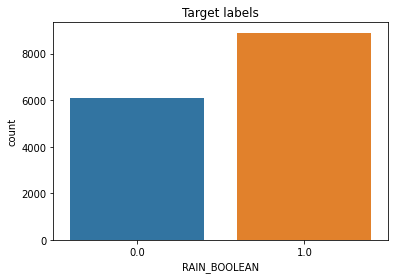

In [15]:
#We can see there are many Null values in the data , lets try to fill with proper values
# sns.set(style="darkgrid")
sns.countplot(read_data.RAIN_BOOLEAN)
plt.title("Target labels")
plt.show()

In [16]:
read_data = read_data.drop(columns = ["I_GRASS_MIN_TEMP","GRASS_MIN_TEMP",
                                      "INDICATOR2","GLOBAL_RADIATION","DOS",
                                      "SOIL_TEMP","INDICATOR0","INDICATOR1",
                                      "INDICATOR2","INDICATOR3","INDICATOR4",
                                      "INDICATOR5","DATE","RAIN_MM","MEAN_CBL_PRESSURE",
                                      "SMD_WELL_DRAINED","SMD_MODERATELY_DRAINED",
                                      "SMD_POORLY_DRAINED","RAIN_BOOLEAN"])
read_data

,MAX_AIR_TEMP,MIN_AIR_TEMP,MEAN_WINDSPEED_KNOT,HIGHEST_10MIN_WINDSPEED,WIND_DIR_DEGREE,HIGHEST_GUST,SUN_DURATION,POTENTIAL_EVAPOTRANSPIRATION,EVAPORATION
13814,12.0,4.5,8.8,16.0,280.0,22.0,4.2,0.7,0.9
13815,11.0,4.0,8.2,12.0,240.0,17.0,0.4,0.6,0.8
13816,15.7,8.8,14.3,24.0,210.0,36.0,0.6,0.8,1.0
13817,12.6,7.1,13.5,24.0,250.0,37.0,6.7,1.0,1.2
13818,11.4,5.5,12.5,19.0,240.0,27.0,7.0,1.2,1.5
...,...,...,...,...,...,...,...,...,...
28819,7.5,1.3,5.5,10.0,270.0,14.0,0.0,0.2,0.3
28820,7.9,-1.2,3.0,7.0,140.0,12.0,4.7,0.1,0.2
28821,10.2,0.6,6.3,11.0,80.0,15.0,0.6,0.3,0.4
28822,10.8,1.9,4.4,10.0,280.0,14.0,1.9,0.2,0.3


<AxesSubplot:>

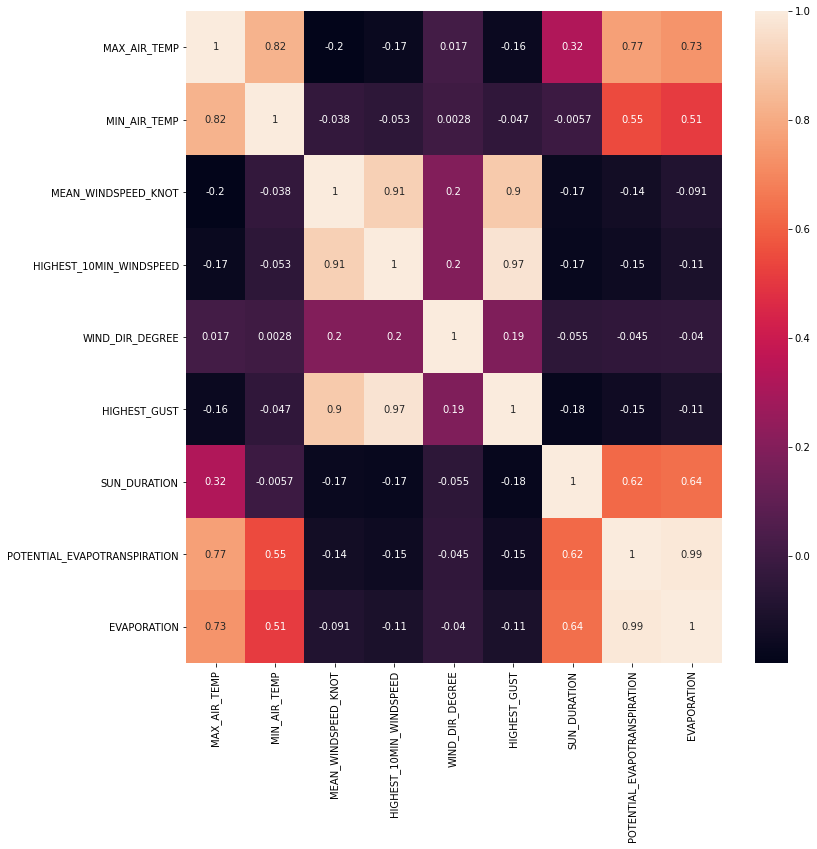

In [17]:
# Correlation between the data Dimensionss 
corrMatrix = read_data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corrMatrix, annot=True,)

In [18]:
column_names = list(read_data.columns)
p_value_max = 1
while (len(column_names)>0):
    p_values= []
    training_with_ColumnValues_1 = read_data[column_names]
    training_with_ColumnValues_1 = sm.add_constant(training_with_ColumnValues_1)
    model = sm.OLS(target_Arr,training_with_ColumnValues_1.astype(float)).fit()
    p_values = pd.Series(model.pvalues.values[1:],index = column_names)      
    p_value_max = max(p_values)
    feature_with_p_max = p_values.idxmax()
    if(p_value_max>0.05):
        column_names.remove(feature_with_p_max)
    else:
        break
final_features = column_names
print("CHOSEN FEATURES : ", final_features)
print(len(final_features))

CHOSEN FEATURES :  ['MAX_AIR_TEMP', 'MIN_AIR_TEMP', 'MEAN_WINDSPEED_KNOT', 'HIGHEST_10MIN_WINDSPEED', 'WIND_DIR_DEGREE', 'HIGHEST_GUST', 'SUN_DURATION', 'POTENTIAL_EVAPOTRANSPIRATION', 'EVAPORATION']
9


In [19]:
max_air_temp = np.array(read_data["MAX_AIR_TEMP"])
min_air_temp = np.array(read_data["MIN_AIR_TEMP"])
mean_windspeed_knot = np.array(read_data["MEAN_WINDSPEED_KNOT"])
wind_dir_degree = np.array(read_data["WIND_DIR_DEGREE"])
highest_gust = np.array(read_data["HIGHEST_GUST"])
sun_duration = np.array(read_data["SUN_DURATION"])
evaporation = np.array(read_data["EVAPORATION"])
potential_evapotranspiration = np.array(read_data["POTENTIAL_EVAPOTRANSPIRATION"])

# max_air_temp = preprocessing.normalize(max_air_temp)
# min_air_temp = preprocessing.normalize(min_air_temp)
# mean_cbl_pressure = preprocessing.normalize(mean_cbl_pressure)
# mean_windspeed_knot = preprocessing.normalize(mean_windspeed_knot)
# wind_dir_degree = preprocessing.normalize(wind_dir_degree)
# highest_gust = preprocessing.normalize(highest_gust)
# sun_duration = preprocessing.normalize(sun_duration)
# evaporation = preprocessing.normalize(evaporation)
# potential_evapotranspiration = preprocessing.normalize(potential_evapotranspiration)

training_data = np.column_stack((max_air_temp,min_air_temp,
                                 wind_dir_degree,highest_gust,sun_duration,
                                 evaporation,potential_evapotranspiration))
norm_training_data = preprocessing.normalize(training_data)
print(norm_training_data)
print("Training data shape : ",training_data.shape)

[[4.26759398e-02 1.60034774e-02 9.95771929e-01 ... 1.49365789e-02
  3.20069548e-03 2.48942982e-03]
 [4.56643234e-02 1.66052085e-02 9.96312511e-01 ... 1.66052085e-03
  3.32104170e-03 2.49078128e-03]
 [7.34238875e-02 4.11547905e-02 9.82102954e-01 ... 2.80600844e-03
  4.67668074e-03 3.74134459e-03]
 ...
 [1.24334690e-01 7.31380531e-03 9.75174042e-01 ... 7.31380531e-03
  4.87587021e-03 3.65690266e-03]
 [3.84929540e-02 6.77190857e-03 9.97965473e-01 ... 6.77190857e-03
  1.06924872e-03 7.12832481e-04]
 [3.75476627e-02 1.03072015e-02 9.93908717e-01 ... 0.00000000e+00
  1.84057170e-03 1.47245736e-03]]
Training data shape :  (15010, 7)


# Baseline Model (predicts class with target value 0 everytime)

In [20]:
target_Arr_baseline = deepcopy(target_Arr)
print(target_Arr)
print(target_Arr_baseline)
for j in range(len(target_Arr_baseline)):
    if target_Arr_baseline[j] == 1:
        target_Arr_baseline[j] = 0
logisticRegression_accuracy_baseline = metrics.accuracy_score(target_Arr,target_Arr_baseline)
print("BASELINE MODEL ACCURACY : ",logisticRegression_accuracy_baseline)

[1 1 1 ... 0 0 1]
[1 1 1 ... 0 0 1]
BASELINE MODEL ACCURACY :  0.4073284477015323


# Logistic Regression Model using Cross-validation.

max_iter Value : 50
LOGISTIC REGRESSION MEAN ACCURACY FOR MAX_ITER=50 USING 10-FOLD CROSSVALIDATION OVER TESTING DATA:  0.709593604263824
MEAN SQUARE ERROR(MSE) VALUES : [0.3117921385742838, 0.3087941372418388, 0.27181878747501664, 0.28247834776815456, 0.27714856762158563]
MEAN OF THE MSEs : 0.2904063957361759
STANDARD DEVIATION OF THE MSEs : 0.01661073247142548 

max_iter Value : 100
LOGISTIC REGRESSION MEAN ACCURACY FOR MAX_ITER=100 USING 10-FOLD CROSSVALIDATION OVER TESTING DATA:  0.7095269820119918
MEAN SQUARE ERROR(MSE) VALUES : [0.3117921385742838, 0.3091272485009993, 0.27181878747501664, 0.28314457028647566, 0.27648234510326447]
MEAN OF THE MSEs : 0.290473017988008
STANDARD DEVIATION OF THE MSEs : 0.016732666303478323 

max_iter Value : 150
LOGISTIC REGRESSION MEAN ACCURACY FOR MAX_ITER=150 USING 10-FOLD CROSSVALIDATION OVER TESTING DATA:  0.7095269820119919
MEAN SQUARE ERROR(MSE) VALUES : [0.3117921385742838, 0.3087941372418388, 0.27181878747501664, 0.28281145902731514, 0.27714

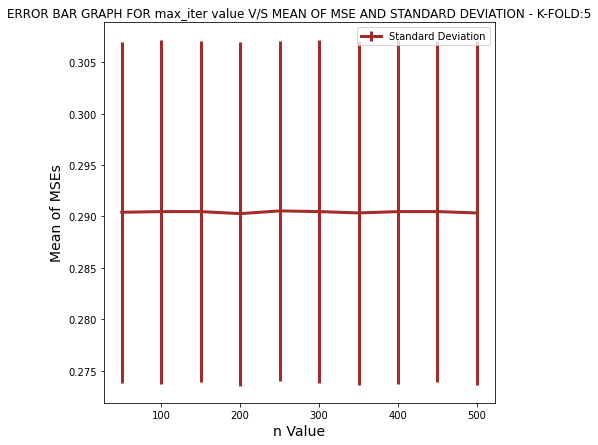

In [21]:
warnings.filterwarnings("ignore")

max_iter_Arr = [50,100,150,200,250,300,350,400,450,500]
mean_error=[]
std_error=[]
mean_accuracy = []
for max_iter_Val in max_iter_Arr:
    kfold_n = 5
    kfold = KFold(n_splits=kfold_n)
    logisticReg = LogisticRegression(penalty="l1",max_iter = 100, solver = "liblinear") #max_iter alteration for different values
    temp=[]
    temp_acc = []
    for train, test in kfold.split(norm_training_data):
        logisticReg.fit(norm_training_data[train], target_Arr[train])
        ypred = logisticReg.predict(norm_training_data[test])
        temp.append(mean_squared_error(target_Arr[test],ypred))
        temp_acc.append(accuracy_score(target_Arr[test],ypred))
        ypred = logisticReg.predict(norm_training_data)
    mean_accuracy.append(np.array(temp_acc).mean()) 
    mean_error.append(np.array(temp).mean())
    std_error.append((np.array(temp).std()))
    print("max_iter Value :",max_iter_Val)
    print("LOGISTIC REGRESSION MEAN ACCURACY FOR MAX_ITER=%d USING 10-FOLD CROSSVALIDATION OVER TESTING DATA: "%max_iter_Val,mean_accuracy[-1])
    print("MEAN SQUARE ERROR(MSE) VALUES :", temp)
    print("MEAN OF THE MSEs :",mean_error[-1])
    print("STANDARD DEVIATION OF THE MSEs :",std_error[-1],"\n")
plt.figure(figsize=(7,7))
plt.errorbar(max_iter_Arr,mean_error,yerr=std_error,linewidth=3, color = "brown")
plt.xlabel('n Value', fontsize = 14)
plt.ylabel('Mean of MSEs', fontsize = 14)
plt.title("ERROR BAR GRAPH FOR max_iter value V/S MEAN OF MSE AND STANDARD DEVIATION - K-FOLD:%s"%str(kfold_n))
plt.legend(["Standard Deviation"], bbox_to_anchor=(1, 1))
plt.show()

In [22]:
logisticReg = LogisticRegression(penalty="l1",max_iter = 240, solver = "liblinear") #max_iter alteration for different values
logisticReg.fit(norm_training_data, target_Arr)
y_pred = logisticReg.predict(norm_training_data)
intercept_value = logisticReg.intercept_
# theta1 = logisticReg.coef_[0,0]
# theta2 = logisticReg.coef_[0,1]
print("INTERCEPT VALUE :", intercept_value[0])
# print("theta1 :", theta1)
# print("theta2 :", theta2)
# print("theta values: "+ str(logisticReg.coef_))


logisticRegression_accuracy = metrics.accuracy_score(target_Arr,y_pred)
print(logisticRegression_accuracy)

INTERCEPT VALUE : -1.7354233513783823
0.7132578281145903


# SVM Model using Cross-validation.

In [23]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(norm_training_data, target_Arr, test_size=0.3)

In [24]:
# #Create a svm Classifier
# classifier = svm.SVC(kernel='linear') # Linear Kernel

# #Train the model using the training sets
# classifier.fit(X_train, y_train)

# #Predict the response for test dataset
# y_Pred = classifier.predict(X_test)

C Value : 0.001
SVM MEAN ACCURACY FOR C value=0.001000 USING 10-FOLD CROSSVALIDATION OVER TESTING DATA:  0.5926715522984678
MEAN SQUARE ERROR(MSE) VALUES : [0.4340439706862092, 0.43737508327781477, 0.3620919387075283, 0.39573617588274485, 0.40739506995336444]
MEAN OF THE MSEs : 0.4073284477015323
STANDARD DEVIATION OF THE MSEs : 0.02755810743940309 

C Value : 0.01
SVM MEAN ACCURACY FOR C value=0.010000 USING 10-FOLD CROSSVALIDATION OVER TESTING DATA:  0.5956029313790806
MEAN SQUARE ERROR(MSE) VALUES : [0.43171219187208526, 0.43704197201865425, 0.357761492338441, 0.39140572951365754, 0.4040639573617588]
MEAN OF THE MSEs : 0.40439706862091934
STANDARD DEVIATION OF THE MSEs : 0.028829042669445453 

C Value : 0.1
SVM MEAN ACCURACY FOR C value=0.100000 USING 10-FOLD CROSSVALIDATION OVER TESTING DATA:  0.6620253164556962
MEAN SQUARE ERROR(MSE) VALUES : [0.37241838774150565, 0.3614257161892072, 0.30013324450366424, 0.3257828114590273, 0.33011325782811457]
MEAN OF THE MSEs : 0.337974683544303

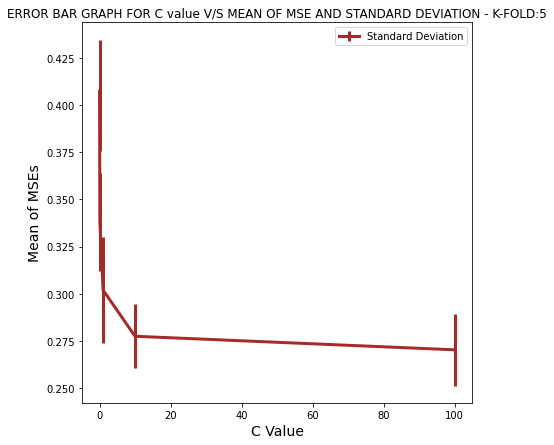

In [25]:
warnings.filterwarnings("ignore")
C_array = [0.001,0.01,0.1,1,10,100]
mean_error=[]
std_error=[]
mean_accuracy = []
for C_value in C_array:
    kfold_n = 5
    kfold = KFold(n_splits=kfold_n)
    svmModel = svm.SVC(C = C_value, kernel = "rbf")
    temp=[]
    temp_acc = []
    for train, test in kfold.split(norm_training_data):
        svmModel.fit(norm_training_data[train], target_Arr[train])
        ypred = svmModel.predict(norm_training_data[test])
        temp.append(mean_squared_error(target_Arr[test],ypred))
        temp_acc.append(accuracy_score(target_Arr[test],ypred))
        ypred = svmModel.predict(norm_training_data)
    mean_accuracy.append(np.array(temp_acc).mean()) 
    mean_error.append(np.array(temp).mean())
    std_error.append((np.array(temp).std()))
    print("C Value :",C_value)
    print("SVM MEAN ACCURACY FOR C value=%f USING 10-FOLD CROSSVALIDATION OVER TESTING DATA: "%C_value,mean_accuracy[-1])
    print("MEAN SQUARE ERROR(MSE) VALUES :", temp)
    print("MEAN OF THE MSEs :",mean_error[-1])
    print("STANDARD DEVIATION OF THE MSEs :",std_error[-1],"\n")
plt.figure(figsize=(7,7))
plt.errorbar(C_array,mean_error,yerr=std_error,linewidth=3, color = "brown")
plt.xlabel('C Value', fontsize = 14)
plt.ylabel('Mean of MSEs', fontsize = 14)
plt.title("ERROR BAR GRAPH FOR C value V/S MEAN OF MSE AND STANDARD DEVIATION - K-FOLD:%s"%str(kfold_n))
plt.legend(["Standard Deviation"], bbox_to_anchor=(1, 1))
plt.show()

In [26]:
#Chosen model with best suited C value.
C_value = 10
svmModel = svm.SVC(C = C_value, kernel = "rbf")
svmModel.fit(norm_training_data,target_Arr)
print("\n-------------------------------\nSVM MODEL TRAINED FOR C=%s.\n-------------------------------"%str(C_value))
SVMintercept_value = svmModel.intercept_
#     SVMtheta1 = svmModel.coef_[0,0]
#     SVMtheta2 = svmModel.coef_[0,1]
print("INTERCEPT VALUE :", SVMintercept_value[0])
#     print("theta1 :", SVMtheta1)
#     print("theta2 :", SVMtheta2)
print("MODEL SCORE FOR C=%s :"%str(C_value),svmModel.score(norm_training_data,target_Arr))
y_pred_SVM = svmModel.predict(norm_training_data)



-------------------------------
SVM MODEL TRAINED FOR C=10.
-------------------------------
INTERCEPT VALUE : -4.987599755516933
MODEL SCORE FOR C=10 : 0.7275816122584944


In [27]:
# print("The Intercept Value: " + str(classifier.intercept_))
# print("The Theta values: " + str(classifier.coef_))

In [28]:
# Model Accuracy: How well the model predicts over the training data?
print("Accuracy: ", metrics.accuracy_score(target_Arr, y_pred_SVM))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision: ", metrics.precision_score(target_Arr, y_pred_SVM))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall: ", metrics.recall_score(target_Arr, y_pred_SVM))

Accuracy:  0.7275816122584944
Precision:  0.7153866833945695
Recall:  0.8973696043165468


# kNN model using cross validation.

N Value : 1
kNN MEAN ACCURACY FOR N=1 USING 10-FOLD CROSSVALIDATION OVER TESTING DATA:  0.6444370419720187
MEAN SQUARE ERROR(MSE) VALUES : [0.3570952698201199, 0.3597601598934044, 0.37108594270486345, 0.3557628247834777, 0.34043970686209196, 0.3564290473017988, 0.3510992671552298, 0.36042638241172553, 0.3344437041972019, 0.3690872751499001]
MEAN OF THE MSEs : 0.3555629580279813
STANDARD DEVIATION OF THE MSEs : 0.010783959329995192 

N Value : 2
kNN MEAN ACCURACY FOR N=2 USING 10-FOLD CROSSVALIDATION OVER TESTING DATA:  0.6139906728847435
MEAN SQUARE ERROR(MSE) VALUES : [0.39040639573617586, 0.3690872751499001, 0.3844103930712858, 0.3770819453697535, 0.3930712858094604, 0.3870752831445703, 0.4043970686209194, 0.3944037308461026, 0.3670886075949367, 0.3930712858094604]
MEAN OF THE MSEs : 0.38600932711525654
STANDARD DEVIATION OF THE MSEs : 0.01120442882247038 

N Value : 3
kNN MEAN ACCURACY FOR N=3 USING 10-FOLD CROSSVALIDATION OVER TESTING DATA:  0.6832778147901399
MEAN SQUARE ERROR(MSE

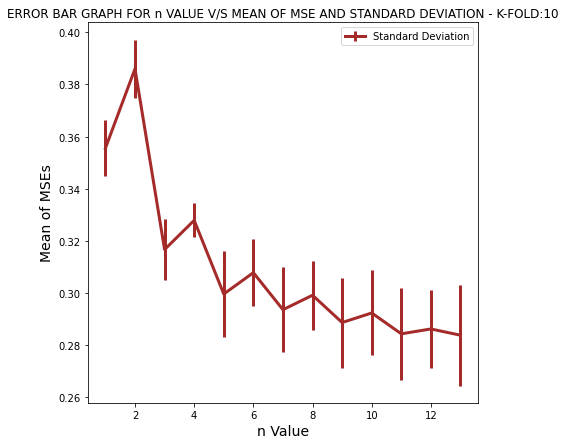

In [29]:
neigh_arr = [1,2,3,4,5,6,7,8,9,10,11,12,13]
mean_error=[]
std_error=[]
mean_accuracy = []
for neigh_size in neigh_arr:
    kfold_n = 10
    kfold = KFold(n_splits=kfold_n)
    model = KNeighborsClassifier(n_neighbors=neigh_size)
    temp=[]
    temp_acc = []
    for train, test in kfold.split(norm_training_data):
        model.fit(norm_training_data[train], target_Arr[train])
        ypred = model.predict(norm_training_data[test])
        temp.append(mean_squared_error(target_Arr[test],ypred))
        temp_acc.append(accuracy_score(target_Arr[test],ypred))
        ypred = model.predict(norm_training_data)
    mean_accuracy.append(np.array(temp_acc).mean()) 
    mean_error.append(np.array(temp).mean())
    std_error.append((np.array(temp).std()))
    print("N Value :",neigh_size)
    print("kNN MEAN ACCURACY FOR N=%d USING 10-FOLD CROSSVALIDATION OVER TESTING DATA: "%neigh_size,mean_accuracy[-1])
    print("MEAN SQUARE ERROR(MSE) VALUES :", temp)
    print("MEAN OF THE MSEs :",mean_error[-1])
    print("STANDARD DEVIATION OF THE MSEs :",std_error[-1],"\n")

plt.figure(figsize=(7,7))
plt.errorbar(neigh_arr,mean_error,yerr=std_error,linewidth=3, color = "brown")
plt.xlabel('n Value', fontsize = 14)
plt.ylabel('Mean of MSEs', fontsize = 14)
plt.title("ERROR BAR GRAPH FOR n VALUE V/S MEAN OF MSE AND STANDARD DEVIATION - K-FOLD:%s"%str(kfold_n))
plt.legend(["Standard Deviation"], bbox_to_anchor=(1, 1))
plt.show()

In [30]:
kNN_Model = KNeighborsClassifier(n_neighbors=7)
kNN_Model.fit(norm_training_data, target_Arr)
print("-----------------------------\nkNN CLASSIFIER MODEL TRAINED.\n-----------------------------")
y_pred = kNN_Model.predict(norm_training_data)
kNN_accuracy = accuracy_score(target_Arr,y_pred)
print("kNN MODEL ACCURACY : ",kNN_accuracy)

-----------------------------
kNN CLASSIFIER MODEL TRAINED.
-----------------------------
kNN MODEL ACCURACY :  0.7751499000666222


# Neural Network Model using Keras.

In [76]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(7,)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l1(0.0001)))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(norm_training_data,target_Arr,epochs=10, batch_size=64, validation_split=0.2)

y_pred = model.predict_classes(norm_training_data)
NN_accuracy = accuracy_score(target_Arr,y_pred)
print("NEURAL NETWORK MODEL ACCURACY : ",NN_accuracy)

Epoch 1/10
188/188 [==============================] - 0s 2ms/step - loss: 0.6843 - accuracy: 0.5636 - val_loss: 0.6737 - val_accuracy: 0.5936
Epoch 2/10
188/188 [==============================] - 0s 2ms/step - loss: 0.6707 - accuracy: 0.5994 - val_loss: 0.6633 - val_accuracy: 0.6076
Epoch 3/10
188/188 [==============================] - 0s 2ms/step - loss: 0.6504 - accuracy: 0.6322 - val_loss: 0.6259 - val_accuracy: 0.6639
Epoch 4/10
188/188 [==============================] - 0s 2ms/step - loss: 0.6192 - accuracy: 0.6661 - val_loss: 0.5971 - val_accuracy: 0.6912
Epoch 5/10
188/188 [==============================] - 0s 2ms/step - loss: 0.6062 - accuracy: 0.6813 - val_loss: 0.5831 - val_accuracy: 0.7049
Epoch 6/10
188/188 [==============================] - 0s 2ms/step - loss: 0.5950 - accuracy: 0.6956 - val_loss: 0.5726 - val_accuracy: 0.7109
Epoch 7/10
188/188 [==============================] - 1s 3ms/step - loss: 0.5915 - accuracy: 0.6989 - val_loss: 0.5679 - val_accuracy: 0.7255
Epoch 

In [31]:
#read_data.to_excel("data_rough.xlsx")
#print("XLSX format file written for observation.")